## This notebook aims to visualize the different asset distributions produced by GAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist



In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)
    
    pre_test_df = df[df.index < start_test_date]
    test_df = df[df.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [3]:
asset_names = returns_df.columns

In [4]:
from WGAN import WGAN_GP
from BiGAN import BiGAN
from solveig_GAN import GAN
from gan2 import GAN2

for asset_name in returns_df.columns:
    print(f"Training WGAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    # Create WGAN instance for the current asset
    gan = GAN2(asset_returns, asset_name)
    
    # Train WGAN for this asset
    gan.train()
    gan.generate_scenarios(num_scenarios=50000)
    
    print(f"Finished training WGAN for {asset_name}.\n")

    # I am breaking early
    break

Training WGAN for REEL...
[Epoch 0/2000] [Batch 0/16] [D loss: -0.005621433258056641] [G loss: 0.10854319483041763]
[Epoch 0/2000] [Batch 10/16] [D loss: -0.011323273181915283] [G loss: 0.12122102826833725]
[Epoch 1/2000] [Batch 0/16] [D loss: -0.020933493971824646] [G loss: 0.2044973522424698]
[Epoch 1/2000] [Batch 10/16] [D loss: 0.0021414756774902344] [G loss: 0.25696861743927]
[Epoch 2/2000] [Batch 0/16] [D loss: -0.025058001279830933] [G loss: 0.2754097282886505]
[Epoch 2/2000] [Batch 10/16] [D loss: -0.049067139625549316] [G loss: 0.3650572597980499]
[Epoch 3/2000] [Batch 0/16] [D loss: -0.03693792223930359] [G loss: 0.4065570831298828]
[Epoch 3/2000] [Batch 10/16] [D loss: -0.0063991546630859375] [G loss: 0.4577098488807678]
[Epoch 4/2000] [Batch 0/16] [D loss: -0.13186651468276978] [G loss: 0.5396013259887695]
[Epoch 4/2000] [Batch 10/16] [D loss: -0.03496807813644409] [G loss: 0.594830334186554]
[Epoch 5/2000] [Batch 0/16] [D loss: -0.02389150857925415] [G loss: 0.603034794330

In [5]:
def create_rolling_empirical(returns_df, window_size=252):
    """Creates rolling 1-year (252-day) sequences from empirical data"""
    rolling_data = []
    for i in range(len(returns_df) - window_size):
        window = returns_df[i : i + window_size]
        rolling_data.append(window)
    return np.array(rolling_data)

def check_mode_collapse(real_returns, generated_returns):
    """
    Checks for mode collapse using:
    1. Variance comparison.
    2. Sample diversity (pairwise distance).
    3. PCA visualization.
    """

    real_var = np.var(real_returns, axis=0).mean()  # Average variance across time steps
    gen_var = np.var(generated_returns, axis=0).mean()

    print(f"Variance of Real Data: {real_var:.6f}")
    print(f"Variance of Generated Data: {gen_var:.6f}")

    if gen_var < 0.5 * real_var:
        print("⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data")
    else:
        print("✅ Generated Data Shows Reasonable Variance")

    # Check for diversity using pairwise distances
    real_distances = pdist(real_returns, metric="euclidean")
    gen_distances = pdist(generated_returns, metric="euclidean")

    real_mean_dist = np.mean(real_distances)
    gen_mean_dist = np.mean(gen_distances)

    print(f"Mean Pairwise Distance (Real): {real_mean_dist:.6f}")
    print(f"Mean Pairwise Distance (Generated): {gen_mean_dist:.6f}")

    if gen_mean_dist < 0.5 * real_mean_dist:
        print("⚠️ Warning: Potential Mode Collapse - Samples are too similar")
    else:
        print("✅ Generated samples are reasonably diverse")

    # PCA Projection for real vs generated data
    pca = PCA(n_components=2)
    real_pca = pca.fit_transform(real_returns)
    gen_pca = pca.transform(generated_returns)

    plt.figure(figsize=(8, 6))
    plt.scatter(real_pca[:, 0], real_pca[:, 1], color="blue", label="Real Returns", alpha=0.5)
    plt.scatter(gen_pca[:, 0], gen_pca[:, 1], color="red", label="Generated Returns", alpha=0.5)
    plt.legend()
    plt.title("PCA Projection of Real vs Generated Returns")
    plt.show()

# ---------- PLOTTING FUNCTION ---------- #
def plot_distributions_with_mode_collapse_check(returns_df):
    asset_names = returns_df.columns

    try:
        plot_boxplots_real_vs_generated(returns_df)
    except:
        print("box plot did not work..")

    plt.figure(figsize=(12, 6))

    for asset_name in asset_names:
        # Load the generated returns for each asset
        gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt')

        # Reshape if needed (batch_size, 252 days)
        gen_returns = gen_returns.view(gen_returns.size(0), 252).cpu().detach().numpy()
        
        # Take rolling 252-day sequences instead of trying to reshape
        empirical_returns = create_rolling_empirical(returns_df[asset_name].values, window_size=252)

        # KDE Plot
        sns.kdeplot(empirical_returns.flatten(), label=f"{asset_name} - Empirical", linestyle="dashed", linewidth=2)
        sns.kdeplot(gen_returns.flatten(), label=f"{asset_name} - Generated", linewidth=2)

        # Check for mode collapse using **252-day sequences**
        check_mode_collapse(empirical_returns, gen_returns)

    plt.title('Distribution of Returns for All Assets', fontsize=16)
    plt.xlabel('Return', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(title='Assets', fontsize=12)
    plt.grid(True)
    plt.show()

# BOX PLOT
def plot_boxplots_real_vs_generated(returns_df):
    asset_names = returns_df.columns

    plt.figure(figsize=(12, 6))

    for asset_name in asset_names:
        # Load the generated returns
        gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt')

        # Reshape if needed (batch_size, 252 days)
        gen_returns = gen_returns.view(gen_returns.size(0), 252).cpu().detach().numpy()

        # Take rolling 252-day sequences instead of trying to reshape
        empirical_returns = create_rolling_empirical(returns_df[asset_name].values, window_size=252)

        # Flatten both for box plot
        data = {
            "Real Returns": empirical_returns.flatten(),
            "Generated Returns": gen_returns.flatten()
        }

        # Convert to DataFrame for Seaborn boxplot
        boxplot_df = pd.DataFrame(data)

        # Create Box Plot
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=boxplot_df)
        plt.title(f"Box Plot for {asset_name}", fontsize=14)
        plt.ylabel("Returns", fontsize=12)
        plt.grid(True)
        plt.show()


box plot did not work..
Variance of Real Data: 0.000167
Variance of Generated Data: 0.000087
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.276380
Mean Pairwise Distance (Generated): 0.183818
✅ Generated samples are reasonably diverse


<Figure size 1200x600 with 0 Axes>

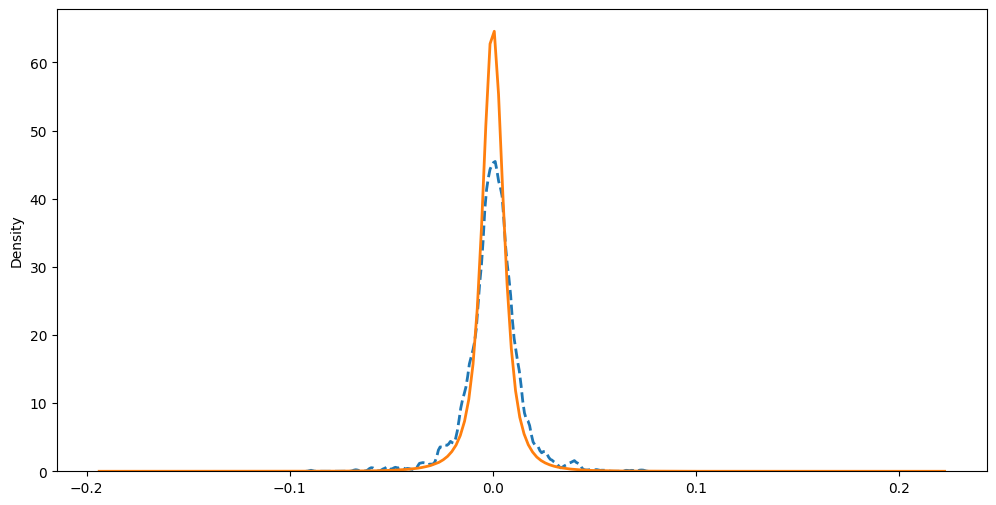

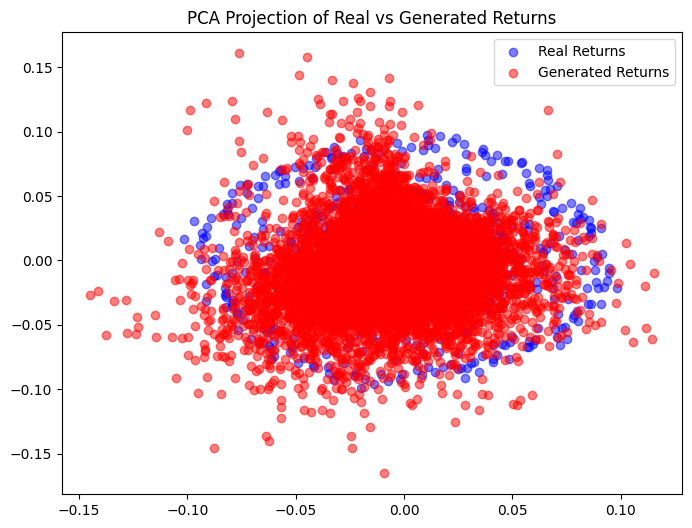

FileNotFoundError: [Errno 2] No such file or directory: 'generated_returns_PE/final_scenarios.pt'

In [6]:
plot_distributions_with_mode_collapse_check(returns_df)

In [ ]:
asset_names = returns_df.columns

asset_names

Index(['REEL', 'PE', 'MSCIWORLD', 'IG', 'GOV', 'HY', 'EONIA'], dtype='object')

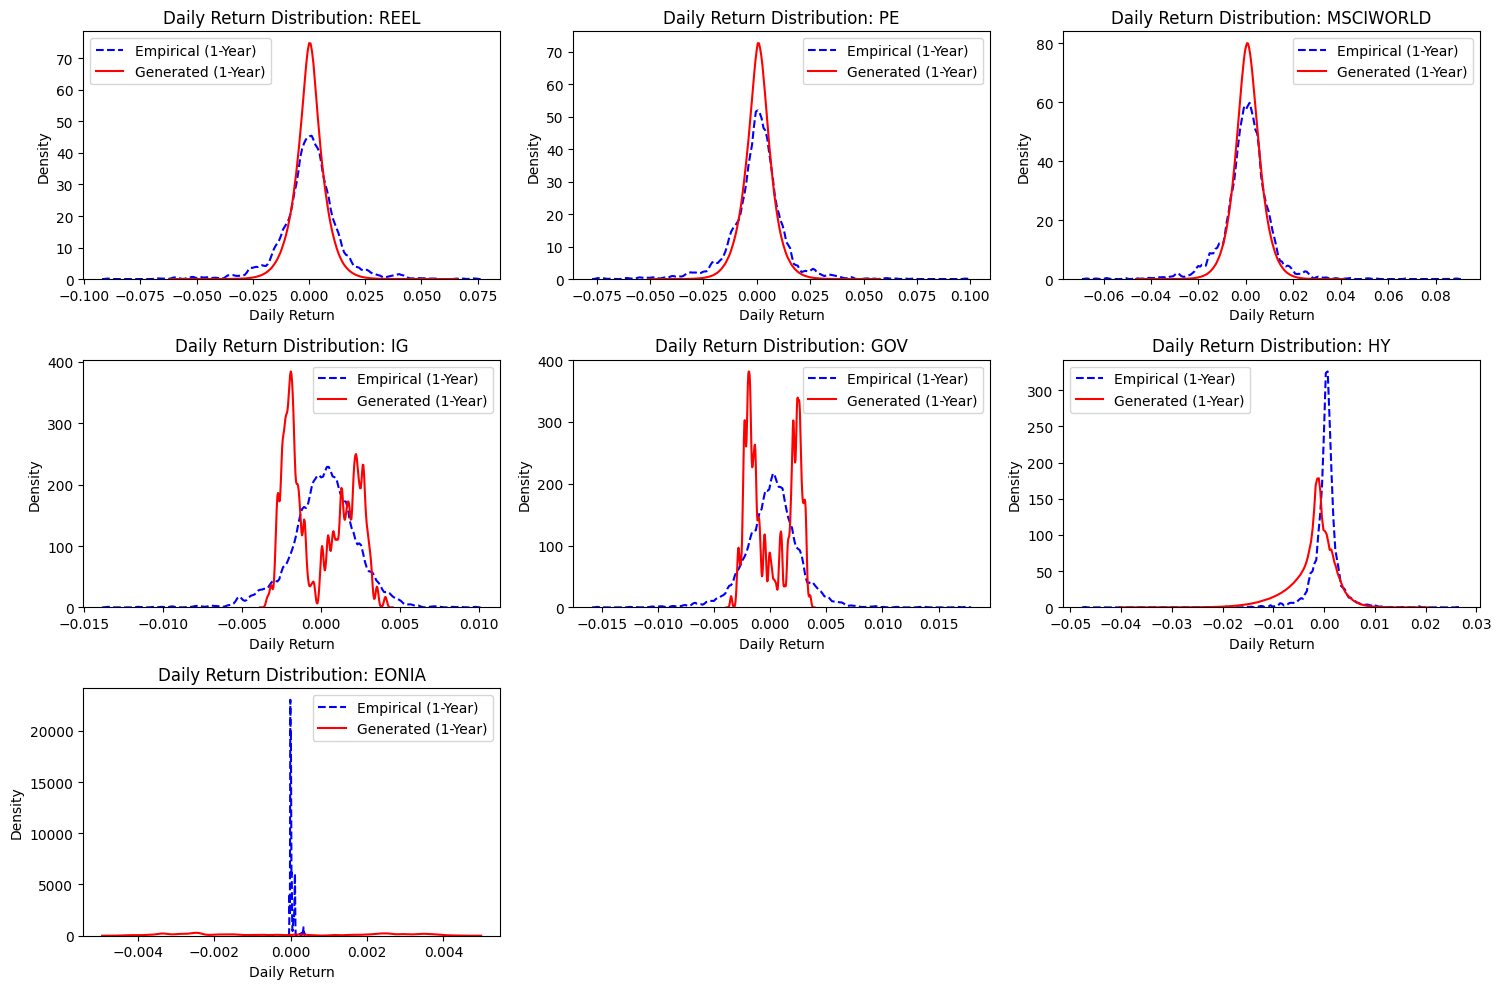

In [ ]:

# Plotting parameters
plt.figure(figsize=(15, 10))

for idx, asset_name in enumerate(asset_names):
    plt.subplot(3, 3, idx + 1)  # Adjust grid size if needed

    # 1. Load generated returns for the asset
    gen_returns = torch.load(f'generated_returns_{asset_name}/final_scenarios.pt')
    gen_returns = gen_returns.view(gen_returns.size(0), 252).cpu().detach().numpy()
    
    # Flatten generated returns across all scenarios and days
    gen_daily_returns = gen_returns.flatten()

    # 2. Extract empirical rolling 1-year daily returns for the asset
    historical_returns = returns_df[asset_name].values
    
    # Create rolling windows of 252 days
    empirical_rolling_returns = [
        historical_returns[i:i + 252] 
        for i in range(len(historical_returns) - 252)
    ]
    
    # Flatten to get daily returns across all rolling windows
    empirical_daily_returns = np.concatenate(empirical_rolling_returns)

    # 3. Plot empirical (1-year rolling) daily returns
    sns.kdeplot(empirical_daily_returns, label='Empirical (1-Year)', color='blue', linestyle='--')

    # 4. Plot generated daily returns
    sns.kdeplot(gen_daily_returns, label='Generated (1-Year)', color='red')

    plt.title(f'Daily Return Distribution: {asset_name}')
    plt.xlabel('Daily Return')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


## Visualizing the data processed by the GAN

In [ ]:
from sklearn.preprocessing import StandardScaler

def create_rolling_returns(returns_df):
    window_size = 252
    scaler = StandardScaler()
    scaled_returns = scaler.fit_transform(returns_df.values.reshape(-1, 1))

    rolling_returns = []
    for i in range(len(scaled_returns) - window_size):
        window = scaled_returns[i:i + window_size]
        rolling_returns.append(window)
    return np.array(rolling_returns), scaler

for asset_name in returns_df.columns:
    print(f"data for {asset_name}...")
    asset_returns = returns_df[asset_name]

    rolling_returns = create_rolling_returns(asset_returns)

    print("rolling returns\n", rolling_returns)
    break

data for REEL...
rolling returns
 (array([[[ 0.23505942],
        [-0.30171276],
        [-1.4927854 ],
        ...,
        [-0.48018767],
        [ 0.61369771],
        [ 0.27041253]],

       [[-0.30171276],
        [-1.4927854 ],
        [-0.64248496],
        ...,
        [ 0.61369771],
        [ 0.27041253],
        [ 0.06811645]],

       [[-1.4927854 ],
        [-0.64248496],
        [-0.30668443],
        ...,
        [ 0.27041253],
        [ 0.06811645],
        [ 0.08049298]],

       ...,

       [[ 0.63423528],
        [ 0.48828482],
        [-0.31129928],
        ...,
        [ 0.36127046],
        [ 0.04317547],
        [ 0.22046786]],

       [[ 0.48828482],
        [-0.31129928],
        [ 0.01487196],
        ...,
        [ 0.04317547],
        [ 0.22046786],
        [ 0.94208522]],

       [[-0.31129928],
        [ 0.01487196],
        [ 1.36280893],
        ...,
        [ 0.22046786],
        [ 0.94208522],
        [-0.40435388]]], shape=(3187, 252, 1)), StandardSca